## Preamble

In [85]:
import random

import numpy

from matplotlib import pyplot
from sklearn import linear_model

# The number of points to include in each (x, f(x)) series.

## "What's Lasso? (A convex optimization.)"

In [86]:
N = 100
xs = numpy.array(list(sorted(random.uniform(-3, 3) for _ in range(N)))).reshape(-1, 1)
ys = numpy.array([xi + random.gauss(0, 0.4) for xi in xs]).reshape(-1, 1)

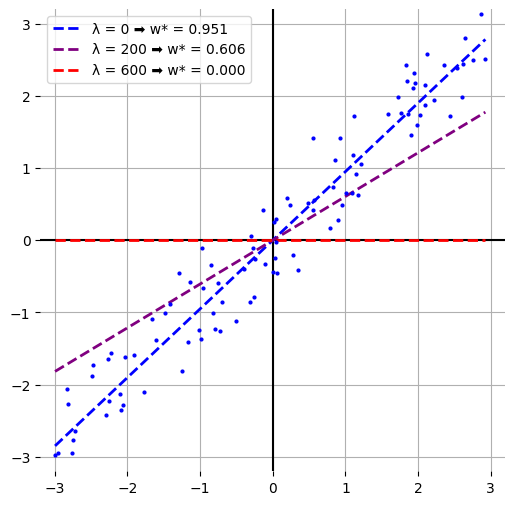

In [111]:
fig = pyplot.figure(figsize=(6, 6))
ax = fig.gca()
ax.axhline(color='k')
ax.axvline(color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

x_lims = [xs[0], xs[-1]]

colors = ['blue', 'purple', 'red']
alphas = [0.001, 1, 3]
for (color, alpha) in zip(colors, alphas):
    model = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    model.fit(xs, ys)
    y_hats = model.predict(x_lims)
    label = f'λ = {alpha * 2 * N:0.0f} ➡️ w* = {model.coef_[0]:0.3f}'
    ax.plot(x_lims, y_hats, color=color, label=label,
            linestyle='--', linewidth=2)
ax.plot(xs, ys, 'b.', markersize=4)
ax.set_xlim(-3.2, 3.2)
ax.set_ylim(-3.2, 3.2)
ax.grid()
ax.legend()

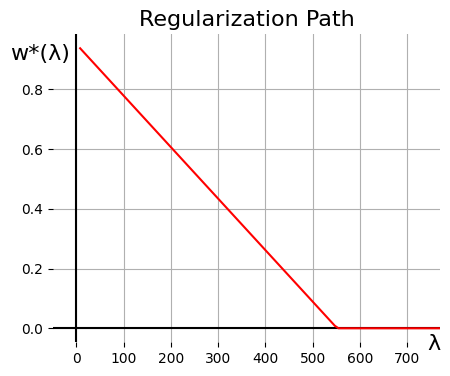

In [122]:
fig = pyplot.figure(figsize=(5, 4))
ax = fig.gca()
ax.axhline(color='k')
ax.axvline(color='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

alpha = 0.001
coef = 1000
while coef > 1e-6:
    model = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    model.fit(xs, ys)
    coef = model.coef_[0]
    #print(f'{alpha:0.3e}, {coef:0.3e}')
    alpha *= 1.25

coefs = []
alphas = []
for alpha in numpy.arange(alpha/100, alpha, alpha/100):
    model = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    model.fit(xs, ys)
    coef = model.coef_[0]
    alphas.append(2 * N * alpha)
    coefs.append(coef)
    #print(f'{alpha:0.3e}, {coef:0.3e}')
ax.set_xlim(-50, 2 * N * alpha)
ax.text(2 * N * alpha, -0.02, 'λ', va='top', ha='right', fontsize=16)
ax.text(-14, 0.9, 'w*(λ)', ha='right', fontsize=16)
ax.set_title('Regularization Path', fontsize=16)
ax.plot(alphas, coefs, 'r-', markersize=3)
ax.grid()
    
    

## Subderivative of the absolute value function

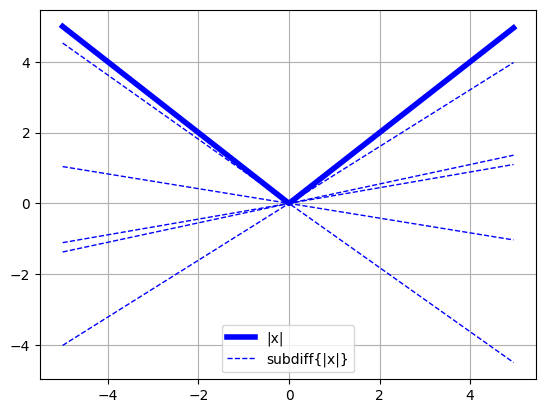

In [81]:

LIMIT = (-5, 5)

_DELTA = (LIMIT[1] - LIMIT[0]) / NUM_POINTS

xs = [i * _DELTA + LIMIT[0] for i in range(NUM_POINTS)]
ys = [abs(xi) for xi in xs]
pyplot.plot(xs, ys, "b-", linewidth=4, label="|x|")

for sub_i in range(5):
    slope = 2 * random.random() - 1
    ys = [slope * xi for xi in xs]
    label = "subdiff{|x|}" if sub_i == 0 else None
    pyplot.plot(xs, ys, "b--", linewidth=1, label=label)

pyplot.grid()
pyplot.legend()

## Unregularized Objective

Set D and S and plot the unregularized regression.

In [82]:
D = 1.2
S = 0.4

X_LIM = (-2, 6)
assert(X_LIM[1] > X_LIM[0])

Y_LIM = (-1, 8)

ARROW_PROPS = dict(
    facecolor='black',
    width=1
)

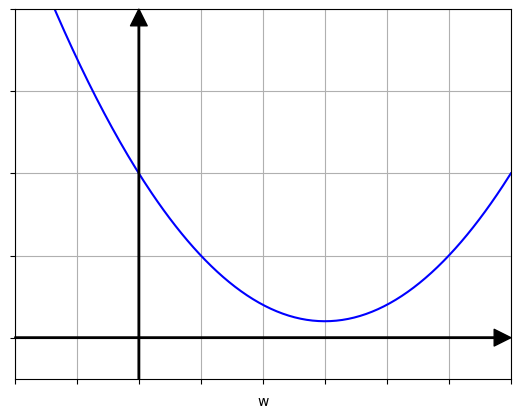

In [83]:
ws = [X_LIM[0] + (X_LIM[1] - X_LIM[0]) *float(i)/NUM_POINTS for i in range(NUM_POINTS+1)]
fu = [S*wi*wi - 2*D*wi + 4 for wi in ws]
pyplot.plot(ws, fu, 'b-', label=r'$\mathcal{L}^{(U)}$')
pyplot.plot([0, 0], Y_LIM, 'k-')
pyplot.annotate(text='', xy=(X_LIM[1], 0), xytext=(X_LIM[0], 0),
               arrowprops=ARROW_PROPS)
pyplot.annotate(text='', xy=(0, Y_LIM[1]), xytext=(0, Y_LIM[0]),
               arrowprops=ARROW_PROPS)
pyplot.xlabel('w')
xloc, _ = pyplot.xticks()
pyplot.xticks(ticks=xloc, labels=['' for xli in xloc])
yloc, _ = pyplot.yticks()
pyplot.yticks(ticks=yloc, labels=['' for yli in yloc])
pyplot.ylim(Y_LIM[0], Y_LIM[1])
pyplot.xlim(X_LIM[0], X_LIM[1])
pyplot.grid()